# Training a Neural Network For Fashion MNIST Dataset

---


# Step 1: Understanding the Dataset and Data Processing
Fashion MNIST  is a Benchmark dataset used for image classification tasks.
1. Goal is to classify grayscale images of fashion items (like t-shirt, shoes,  bag, trouser etc..)  it has a total of 10 classifications hence a multi-class classification problem.
2. Total no of images are 70,000 (60,000 - training , 10,000 - testing)
3. Size of Image 28 x 28 pixels
4. Only 1 color channel (grayscale images) pixel value ranges from 0(black) - 255(white) - values inbetween represents shades of grey
5. Example

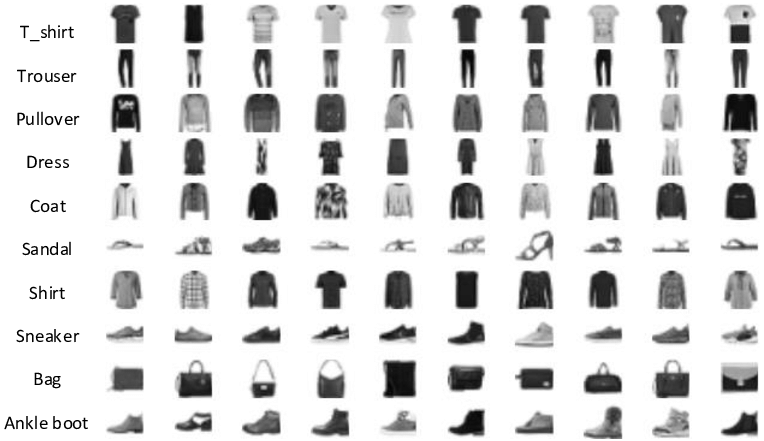

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
!pip install -U scikit-learn scikeras[tensorflow] # Lets us use keras models inside GridSearch

In [3]:
#we can directly upload the dataset from keras.datasets
dataset = keras.datasets.fashion_mnist
(X_train , y_train) ,(X_test , y_test) = dataset.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

Total of 60000 training images of (28 x 28) pixels and 10000 testing images of same (28 x 28) pixels

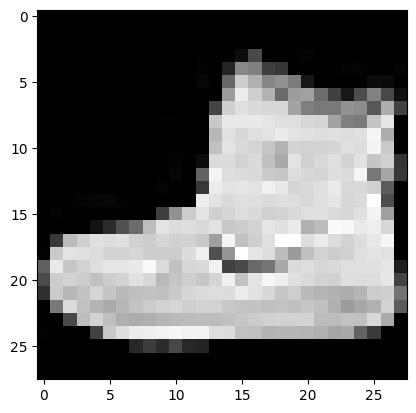

In [6]:
# A sample Input
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [7]:
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

 You could see  (28 rows and 28 columns. each cell representing a pixel value) this is how image is passed as an input to the Neural Network Since we are using Traditional Neural Nets we have to flatten to send as Input.

In [8]:
# we are here taking the first 6000 images from the train set as validation set
X_val , X_train_new = X_train[:6000]/255 , X_train[6000:]/255
y_val , y_train_new = y_train[:6000] , y_train[6000:]
X_test = X_test/255

We divide the input data by 255 to normalize pixel values in an image
1. By scaling values to [0,1] Neural Networks are known to perform best.
2. Gradients stay safe during backpropagation and stabilizes learning


In [9]:
X_val.shape

(6000, 28, 28)

# Step 2: Building the Model
1. Here is where we start building the model and I will explain my approach and the intuition behind it.
2. Neural Nets dont just map input to out. Think of each layer as: Taking the input , Expanding it into a higher dimensional space. then compressing it into useful learnable structures.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

In [11]:
def build_model(neurons=128, dropout_rate=0.3, learning_rate=0.001):
  model = Sequential([
      Flatten(input_shape=(28,28)),
      Dense(neurons,activation='relu'),
      Dropout(dropout_rate),
      Dense(64,activation='relu'),
      Dropout(dropout_rate),
      Dense(10,activation='softmax')
  ])

  optimizer = Adam(learning_rate = learning_rate)
  model.compile(optimizer=optimizer , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

1. Input Layer : Flatten Converts each 2D image into a 1D array of features (28 x 28 = 784 inputs) Traditional Neural Nets can only handle flat 1D Arrays as inputs.
2. Hidden Layer 1 : First Hidden Layer with neurons (64 or 128 from Grid search). Regarding the A.F choosen Relu is a safe choice. it is defined as f(x) = max(0,x). Relu Avoids Vanishing Gradient Problem. Relu is faster (Computationally efficient) because it is just max(0,x) but sigmoid and tanh have exp(x) terms. Relu also can suffer from the Vanishing Gradient problem but since this is not a Deep Neural Network (2 - Hidden Layers) Relu is the most appropriate and safe choice for this problem.
3. Dropout : Prevents overfitting by randomly turning off neurons during training. a dropout of 0.3 means 30 percent of the neurons are randomly turned off during each training step. This is one of the Regularization technique performed to prevent the model memorizing
4. Hidden Layer 2 : Second Hidden Layer where a smaller layer helps narrow down the learned representation
5. Dropout : Again we implement Dropout.
6. The final output layer will have 10 Neurons Why so? because we have 10 classes in our classification problem. if we have n classes there will be n neurons in the output layer. we use softmax as activation function because these output values need to be interpreted. it ensures all output neurons sum up to 1 which makes it interpretable. it asks the question what is the probability this input belongs to each class?.
7. We are using an Adam Optimizer which uses adaptive learning rates which makes it a good default choice for this problem learning_rate = 0.001 - This is Adam's default choice which is not too high (model may never converge) or too low (model takes a lot of time to converge)
8. The Loss Function is : Sparse Categorical Cross Entropy. Both Categorical Cross Entropy and Sparse Categorical Cross Entropy Compute the same loss value but we use Sparse Categorical Cross Entropy when our Label Format (Target Values) are Integers in the other method our Label format is one hot encoded.

In [12]:
# Wraps the build_model function in a way GridSearchCV can understand it as it is scikit-learn package
model = KerasClassifier(model=build_model, verbose=0)


In [13]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [5, 10],
    'model__neurons': [64, 128],
    'model__dropout_rate': [0.3],
    'model__learning_rate': [0.001, 0.0005]
}


We are defining the parameters here.
1. batch_size : Controls How many samples the model sees before updating the weights. after each batch is complete weights are updated.
2. epochs : An epoch means the model has seen every training sample exactly once. 1 epoch = one full through X_train fully.
3. model__neurons : controls the number of neurons in the first hidden layer.
4. model__dropout : sets how much layer is randomly deactivated during training
5. model__learning_rate : controls updation of weights

There are a total of : 2 x 2 x 2 x 1 x 2 = 16 total combinations each is trained using 3 fold cross validation so 16 x 3  = 48 models

In [14]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train_new, y_train_new)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Grid Search is a Technique to automatically Find the best Hyperparameters for your model by trying out all defined combinations from a predefined set.
1. Why do we use this?
2. Neural Networks have many hyperparameters that can be tuned like :
no of neurons in a layer , Dropout rate , learning rate , batch size and epochs instead of random guessing and a lot of trial and error work. Grid Search automates this and finally provides the best set of combinations.
3. it is not strictly required for k-fold cross validation as we already have our own validation set.  Just for demonstration purposes i am doing this.
4. Only Disadvantage with grid search is  it takes a lot of time. that is the reason for me to  consider having less epochs and less combinations already I am computing 48 models.

In [15]:
print("Best Accuracy: {:.2f} using {}".format(grid_result.best_score_, grid_result.best_params_))


Best Accuracy: 0.88 using {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0005, 'model__neurons': 128}


This gives you the best combination of the model which gives rise to 0.88 accuracy

In [16]:
best_params = grid_result.best_params_


In [17]:
# Extract values
best_neurons = best_params['model__neurons']
best_dropout = best_params['model__dropout_rate']
best_lr = best_params['model__learning_rate']

# Build final model
final_model = build_model(neurons=best_neurons, dropout_rate=best_dropout, learning_rate=best_lr)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
history = final_model.fit(
    X_train_new, y_train_new,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_val,y_val),
    verbose=2
)

Epoch 1/10
1688/1688 - 5s - 3ms/step - accuracy: 0.8357 - loss: 0.4663 - val_accuracy: 0.8922 - val_loss: 0.3002
Epoch 2/10
1688/1688 - 9s - 5ms/step - accuracy: 0.8502 - loss: 0.4217 - val_accuracy: 0.8852 - val_loss: 0.3046
Epoch 3/10
1688/1688 - 6s - 3ms/step - accuracy: 0.8567 - loss: 0.3984 - val_accuracy: 0.8895 - val_loss: 0.2975
Epoch 4/10
1688/1688 - 5s - 3ms/step - accuracy: 0.8614 - loss: 0.3830 - val_accuracy: 0.8970 - val_loss: 0.2869
Epoch 5/10
1688/1688 - 4s - 2ms/step - accuracy: 0.8681 - loss: 0.3685 - val_accuracy: 0.8945 - val_loss: 0.2860
Epoch 6/10
1688/1688 - 5s - 3ms/step - accuracy: 0.8713 - loss: 0.3561 - val_accuracy: 0.8945 - val_loss: 0.2896
Epoch 7/10
1688/1688 - 5s - 3ms/step - accuracy: 0.8714 - loss: 0.3495 - val_accuracy: 0.8937 - val_loss: 0.2847
Epoch 8/10
1688/1688 - 7s - 4ms/step - accuracy: 0.8755 - loss: 0.3399 - val_accuracy: 0.8930 - val_loss: 0.2876
Epoch 9/10
1688/1688 - 4s - 3ms/step - accuracy: 0.8798 - loss: 0.3325 - val_accuracy: 0.8922 - 

Training the model using best possible combinations and using the validation data that was split at the start

In [32]:
final_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)

This is the model summary for the Final model which has the best hyperparameters. lets decode this.
1. Input Layer takes input of size 784
2. There are a total of 128 Neurons in hidden layer 1 so all neurons will be connected to the input neurons so no of parameters = 128 x 784 + 128(bias) = 100,480 params
3. Dropout implemented
4. Hidden layer 2 has 64 neurons these 64 neurons are connected to 128 neurons in H.L 1 so 64 x 128 + 64(bias) = 8256 params
5. Dropout implemented
6. output layer has 10 neurons each is connected to 64 neurons in H.L 2 so 10 x 64 + 10(bias) = 650 params
7. Total params trainable = 109,386

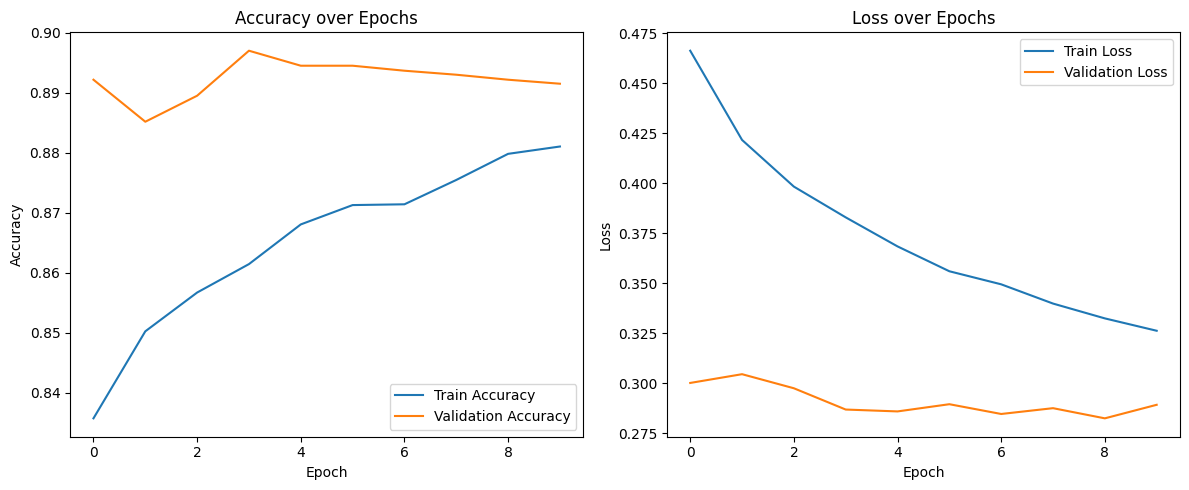

In [33]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1. We could infer although accuracy is increasing Training accuracy = 88 percent and validation accuracy close to 89 percent. This is a good sign. which means model performs well on unseen data

2. Train loss Decreases and Val loss drops from 0.300 - 0.289 and is not increasing so no sign of overfitting. But my model validation loss is lower than training loss which might happen due to slight sample variation between validation set and train set.
3. But overall model has good accuracy performs well on both validation and testing set.

In [34]:
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print("Final Test Accuracy: {:.2f}".format(test_accuracy))
print("Final Test Loss:{:.2f}".format(test_loss))


Final Test Accuracy: 0.88
Final Test Loss:0.35


Model performs in the same level on test data as well. which is a sign of a good model.

In [35]:
y_pred_probs = final_model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [36]:
y_pred_classes = np.argmax(y_pred_probs, axis=1)

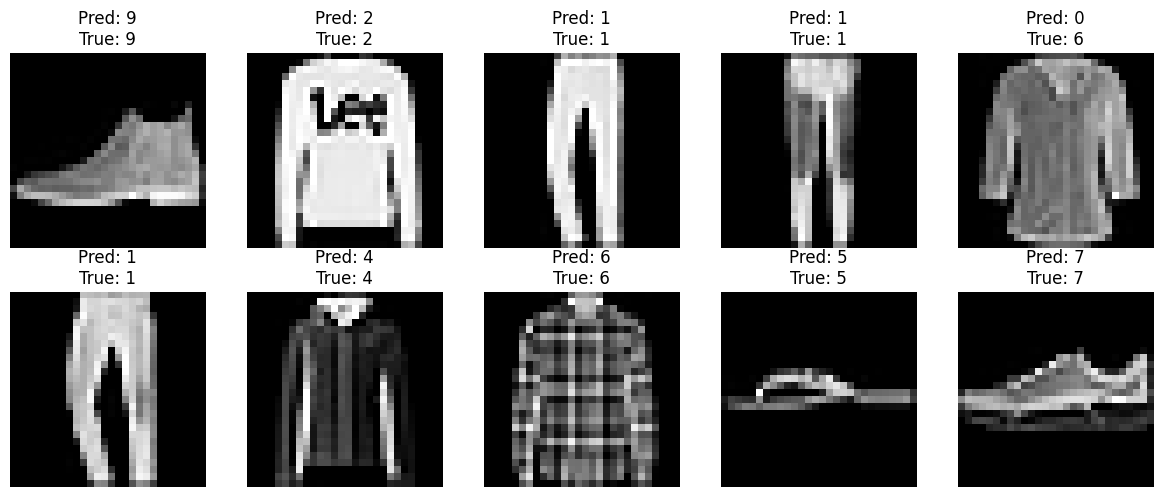

In [37]:
class_names = [str(i) for i in range(10)]

plt.figure(figsize=(12,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Pred: {y_pred_classes[i]}\nTrue: {y_test[i]}")
    plt.axis('off')


plt.tight_layout()
plt.show()

Just to Visualize our predicted and Target Values. Our model does well.

To avoid Overfitting
1. Dropout Regularization
2. Hyperparameter Tuning with GridSearch (Cross Validation) - Cross validation ensures selected model performs consistently across multiple splits.
3. I have clearly demonstrated just with 2 hidden layers and 10 epochs my model can perform Well on not just training data but all of training, testing and Validation data all have a closeby accuracy which means the model generalizes well.

# Final Conculsion and Learning

Since The Question Demanded a traditional Neural Network we have implemeted one but for the curious ones  the quesion may arise then Why CNN in the first place. because if traditional neural nets can do Image classification why do we use CNN so I research through it and this was my understanding

1. Since this was a Simple Fashion MNIST dataset Traditional Neural Nets could perform well but for complex image classification which involves color channels Traditional Neural cant perform well the reason:
2. when we flatten out before sending it to the input neurons we essentially remove the spatial awareness present in the image. for example a dog ears distance and a cat ear difference can vary. they loss critical features like edges texture etc.
3. Moving an object slightly or rotating it can change every pixel which T.N.N cant capture.
4. This is the reason why CNN came into the picture which were specifically designed for visual tasks and to respect spatial structure.

5. This Assignment most importantly taught me about how to optimise parameters in the best way possible for Neural Nets and the answer was GridSearch where the main disadvantage of it is Training time because it has to go through all combinations.